In [1]:
#  A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 7.2MB/s 


In [2]:
# You will use the AdamW optimizer from tensorflow/models so i will donload the models
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 37.6MB 83kB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 1.2MB 57.9MB/s 
     |████████████████████████████████| 706kB 56.4MB/s 
     |████████████████████████████████| 174kB 68.1MB/s 
     |████████████████████████████████| 645kB 50.3MB/s 
     |████████████████████████████████| 102kB 16.1MB/s 
     |████████████████████████████████| 358kB 46.9MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [4]:
# load the data from imdb dataset and remove the shit thing from the data
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 1s 0us/step


In [5]:
# Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.
# The IMDB dataset has already been divided into train and test, but it lacks a validation set.
#  Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)
# now i will get the class from the dic and try not to shuffle the data
class_names = raw_train_ds.class_names
# here i use prefetch to prepare the next element of the data 
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# after i got the data for train now i will make the same thing for the val
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
# the same fucken shit as the train
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# get the test data from anthour dic
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
# Let's take a look at a few reviews.
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [7]:
# now it's time for load the model from tensorflow hub and also  the process model
# here i will use this two model to fine tun the sentiment review project
tfhub_handle_encoder ='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
# now i will use hub.kerasLayer to call the process model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
# Let's try the preprocessing model on some text and see the output:
# what we did when we load the model that now we don't need to write any thing to process the text for us it's alraedy here
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# now after we use the process model now we will use the bert model
# the same thig we did with the process model we will do here
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626285   0.9928097  -0.18611872  0.36673838  0.15233651  0.65504503
  0.9681153  -0.9486271   0.00216202 -0.98777324  0.06842704 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894633   0.3432127   0.3323149  ...  0.21300851  0.71020794
  -0.05771134]
 [-0.28742072  0.31981015 -0.23018585 ...  0.58455116 -0.21329728
   0.72692126]
 [-0.6615698   0.6887679  -0.87433    ...  0.10877296 -0.26173288
   0.47855446]
 ...
 [-0.22561117 -0.28925592 -0.0706448  ...  0.47566015  0.8327718
   0.4002533 ]
 [-0.29824197 -0.27473164 -0.05450563 ...  0.48849764  1.0955356
   0.1816339 ]
 [-0.4437818   0.00930747  0.07223698 ...  0.17290133  1.1833245
   0.0789803 ]]


In [12]:
# now we will define the model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()

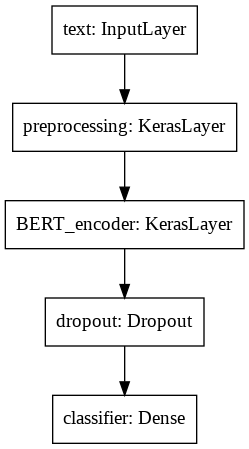

In [14]:
# we can see the structur of the model
tf.keras.utils.plot_model(classifier_model)

In [15]:
# now let's tranin the model
# but first let's define a loss function
# Since this is a binary classification problem and the model outputs a probability
#  (a single-unit layer), you'll use losses.BinaryCrossentropy loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [24]:
# now let's define the optimizer like the bert model is originally deifned
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
# Loading the BERT model and training
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [26]:
# now let's make the fit or train the model
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 160s 251ms/step - loss: 0.5771 - binary_accuracy: 0.6233 - val_loss: 0.3884 - val_binary_accuracy: 0.8052
Epoch 2/5
625/625 [==============================] - 155s 249ms/step - loss: 0.3558 - binary_accuracy: 0.8372 - val_loss: 0.3931 - val_binary_accuracy: 0.8304
Epoch 3/5
625/625 [==============================] - 156s 250ms/step - loss: 0.2738 - binary_accuracy: 0.8830 - val_loss: 0.4079 - val_binary_accuracy: 0.8388
Epoch 4/5
625/625 [==============================] - 157s 251ms/step - loss: 0.2116 - binary_accuracy: 0.9165 - val_loss: 0.4442 - val_binary_accuracy: 0.8472
Epoch 5/5
625/625 [==============================] - 157s 251ms/step - loss: 0.1609 - binary_accuracy: 0.9369 - val_loss: 0.4850 - val_binary_accuracy: 0.8510


In [27]:
# Evaluate the model
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 86s 110ms/step - loss: 0.4582 - binary_accuracy: 0.8554
Loss: 0.45824694633483887
Accuracy: 0.8554400205612183


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


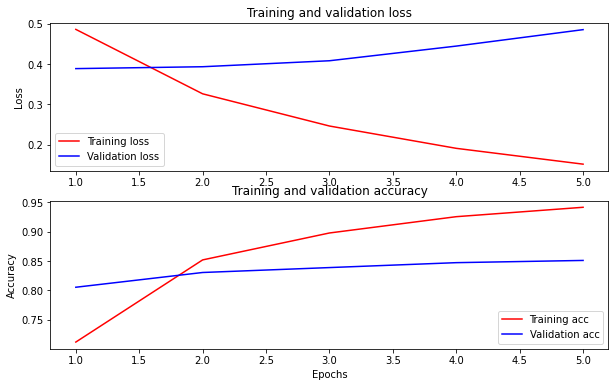

In [28]:
# Plot the accuracy and loss over time
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [29]:
# now let's save the model
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [32]:
# now let's reload the model
reloaded_model = tf.saved_model.load(saved_model_path)

In [31]:
# let's create a function to see the acc of the model
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999428
input: The movie was great!           : score: 0.994326
input: The movie was meh.             : score: 0.976239
input: The movie was okish.           : score: 0.024771
input: The movie was terrible...      : score: 0.000559

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999428
input: The movie was great!           : score: 0.994326
input: The movie was meh.             : score: 0.976239
input: The movie was okish.           : score: 0.024771
input: The movie was terrible...      : score: 0.000559

